For the background on this simulation, see http://publish.illinois.edu/ymb/2020/03/14/keeping-your-teams-safe/.

Start with the usual:

In [34]:
import numpy as np
import matplotlib.pyplot as plt

*MaxIncubation* is just a marker for a healthy person; *Contagious* parameter is an estimate 
of how many hours before symptoms become apparent, the infected person becomes contagious.

In [35]:
MaxIncubation=100000;
Contagious=48;

To prepare some simulated schedules: periodic...

In [52]:
def MakePeriodic(shift,timeslots,rotation):
    a=np.zeros([len(shift),timeslots]);    
    for t in range(timeslots):
        a[:,t]=np.roll(shift,rotation*t);
    return(a.astype(int))

...and random

In [53]:
def MakeTwoTeamsRandom(team,timeslots):
    a=np.zeros([2*team,timeslots]);
    a[0:team,0]=np.ones(team);
    for c in range(timeslots):
        a[:,c]=a[np.random.permutation(2*team),0];
    return(a.astype(int))

Count how many on the team are infected, but asymptomatic (not removed)

In [54]:
def TeamCountsCon(t,numberteams,assignment,state):
    count=np.zeros(numberteams);
    crew=np.shape(state)[0];
    for i in range(crew):
        if (state[i,t-1]<Contagious) and (0<state[i,t-1]):
            count[assignment[i,t]-1]+=1;
    return count;

Random process of infection at work: note that we assume that peope become contagious only when they are
close to symptoms (4 days, - and this might be too high or too low!), and asymptomatic (we assume
that once symptoms manifest, the workers stays at home).

In [55]:
def InfectWork(countinfected):
    infect=(1-InfRateWork/24*HperSlot)**countinfected<np.random.random()
    return infect

...and at home.

In [56]:
def InfectHome():
    infect=(1-InfRateHome*HperSlot/24)<np.random.random()
    return infect

Important parameter: we approximate incubation time as log-normal, with parameters 1.62 and .418 (see https://www.mdpi.com/2077-0383/9/2/538)

In [57]:
def IncubationTime():
    return 24*np.random.lognormal(1.62,.418); # incubation period ~ lognormal: reference

One simulation run

In [58]:
def Run(assignment):
    # prepare state MaxIncubation if healthy, 0<T<MaxIncubation if latent
    # infected, 0 if symptomatic
    [Crew,Tslots]=np.shape(assignment);
    NumberTeams=np.max(assignment);
    State=np.zeros([Crew,Tslots]);
    # Initialize:
    for i in range(Crew):
        State[i,0]=MaxIncubation; #all healthy

    InfectedAtWork=0;
    # Actual run
    for t in range(1,Tslots):
        Count=TeamCountsCon(t-1,NumberTeams,assignment,State);
        for i in range(Crew):
            if State[i,t-1]==MaxIncubation: # if healthy
                if (assignment[i,t]==0 and InfectHome()): #Infected
                    State[i,t]=IncubationTime();
                elif (assignment[i,t]>0 and InfectWork(Count[assignment[i,t]-1])):
                    State[i,t]=IncubationTime();
                    InfectedAtWork+=1;
                else:
                    State[i,t]=MaxIncubation;
            elif State[i,t-1]>0:            # latent
                State[i,t]=State[i,t-1]-HperSlot;
            elif State[i,t-1]<=0:
                State[i,t]=0;
    return(State)

Perform many runs:

In [59]:
def Iterate(iterations, assignment):
    InfectedTotal=[];
    WorkingTotal=[];
    SymptomTime=[];
    InfectedAtSymptomTime=[];
    for t in range(iterations):
        state=Run(assignment);
        InfectedTotal.append(sum(state[:,-1]<MaxIncubation));
        WorkingTotal.append(sum(sum((state>0)*(assignment>0))));
        SymptomTime.append(sum(sum(state<=0)==0));
        InfectedAtSymptomTime.append(sum(state[:,sum(sum(state<=0)==0)-1]<MaxIncubation));
    return [InfectedTotal,WorkingTotal,SymptomTime,InfectedAtSymptomTime]

Set the infections rate: *InfRateHome* is just the chance to get infected while away from work (per day). Infection rates at work *InfRateWork* are trickier: it is the chances to get infected by one contagious colleague (per work day). If one has multiple contagious coworkers, the rate (on the given location) increases correspondingly.
*HperSlot* is a variable for future more detailed simulations (right now we assume that both work and home are simple 24 hours periods).

In [60]:
InfRateWork=.05; 
InfRateHome=.01;
HperSlot=24;

Here we prepare a few scheduling options. 

**In the real life applications**, the table *Assignments* - which has rows for the workers, columns for time slots, -
should be populated by placing 0 for staying at home, *k>=1* for workday with team *k*.

Below we prepare some perioding assinments (*p* days at work, *p* days at home) or random ones.

In [61]:
team=10;      #size of each team
timeslots=60;
shift1=[0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2]; # 10 workers split into 2 non-interacting teams
shift2=[0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]; # 10 workers share workspace
rotate=5;

Assignment1=MakePeriodic(shift1,timeslots,rotate);
Assignment2=MakePeriodic(shift2,timeslots,rotate);
Assignment3=MakeTwoTeamsRandom(team,timeslots);

Time to do acual run: we do *iter* runs per schedule.

In [63]:
iter=400;

[I1,W1,S1,A1]=Iterate(iter,Assignment1);
[I2,W2,S2,A2]=Iterate(iter,Assignment2);
[I3,W3,S3,A3]=Iterate(iter,Assignment3);

output results:


 team of 20 
 at work infection rate/contagious person: 0.05 
 at home infection rate: 0.01 
 time horizon: 60


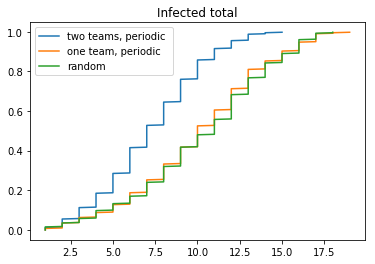

In [65]:
print('\n team of',str(np.shape(Assignment1)[0]),'\n at work infection rate/contagious person:',str(InfRateWork),'\n at home infection rate:',str(InfRateHome),'\n time horizon:',str(np.shape(Assignment1)[1]))

x=np.arange(len(I1))/len(I1);

legend1='two teams, periodic ';
legend2='one team, periodic ';
legend3='random'

plt.plot(np.sort(I1),x,np.sort(I2),x,np.sort(I3),x)
plt.legend((legend1, legend2, legend3))
plt.title('Infected total')
plt.show()

the plot above is the *cumulative distribution function*: for any $x$, 
    the $y$ coordinate is the probability that your total number of infected 
    is less than this height. So, the higher the plot is, the better.
    The area of the NW part of the plot above the corresponding curve is 
    the average number of the infected, somthing you should probably pay 
    the most attention to.